In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 
import torch

import os 
from torch import nn 
import torch.nn.functional as F

In [15]:
training_data = datasets.FashionMNIST(
    root ='data', train = True, download= True, 
    transform= ToTensor() 
)

test_data = datasets.FashionMNIST(
    root ='data', train = False, download= True, 
    transform= ToTensor() 
)

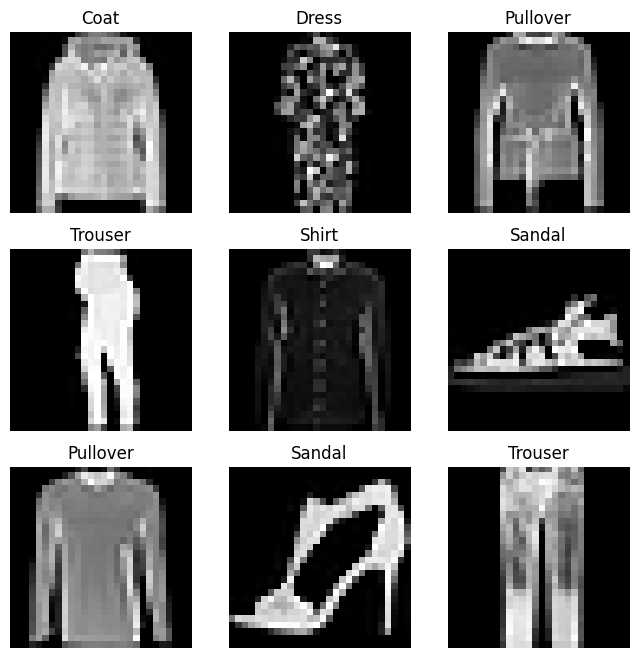

In [3]:
labels_map = {
    0 : 'T-Shirt', 
    1 : 'Trouser', 
    2 : 'Pullover', 
    3 : 'Dress', 
    4 : 'Coat', 
    5 : 'Sandal', 
    6 : 'Shirt', 
    7 : 'Sneaker', 
    8 : 'Bag', 
    9 : 'Ankle Boot'
}

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows+1) : 
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [4]:
# shuffle the batches 
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [5]:
# choose GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2050


### Modeling

In [6]:
# its a 28 x 28 matrix and we flatten it into 784 x 1 1st 
len(training_data[0][0][0])

28

In [7]:
class NeuralNetwordk(nn.Module) : 
    def __init__(self) : 
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # input 28x28 ==> output 512
            nn.Linear(in_features=28*28, out_features=512, bias=True), 
            nn.ReLU(), 
            nn.Linear(in_features=512, out_features=512, bias=True), 
            nn.ReLU(),
            # don't use activation
            nn.Linear(in_features=512, out_features=10, bias=True)
        ) 
    
    def forward(self, x) : 
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwordk().to(device)
print(model)

NeuralNetwordk(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
X = torch.rand(1, 28, 28, device=device) # random X 
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(y_pred)

tensor([6], device='cuda:0')


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)     # 1 input channel (grayscale), 6 output
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # For 28x28 input:
        # conv1: (28 - 5 + 1) = 24 → pool → 12
        # conv2: (12 - 5 + 1) = 8 → pool → 4
        # final feature map: 16 × 4 × 4 = 256
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Output: [B, 6, 12, 12]
        x = self.pool(F.relu(self.conv2(x)))   # Output: [B, 16, 4, 4]
        x = torch.flatten(x, 1)                # Flatten to [B, 256]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Training

In [10]:
learning_rate = 1e-3
batch_size = 64

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer) : 
    size = len(dataloader.dataset)

    model.train() # train state 
    for batch, (X, y) in enumerate(dataloader) : 
        X, y = X.to(device), y.to(device) # move to gpu / same device to avoid device mismatch error
        # compute prediction and loss 
        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop 
        loss.backward() # compute gradient 
        optimizer.step() # update values 
        optimizer.zero_grad() # refresh gradients and make it 0
        if batch%100 == 0 : 
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"Loss : {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn) : 
    model.eval() # eval state 
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0 

    with torch.no_grad() : # no gradients are computed 
        for X, y in dataloader : 
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float32).sum().item()

    test_loss /= num_batches
    correct /= size 
    print(f"Test Error: \n Accuracy : {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
epochs = 10
for t in range(epochs) : 
    print(f"Epoch {t+1} \n {'='*20}")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)    

print('done')

Epoch 1 
Loss : 0.676149  [   64/60000]
Loss : 0.742332  [ 6464/60000]
Loss : 0.947479  [12864/60000]
Loss : 0.848914  [19264/60000]
Loss : 0.852646  [25664/60000]
Loss : 0.748634  [32064/60000]
Loss : 0.823766  [38464/60000]
Loss : 0.685011  [44864/60000]
Loss : 0.831259  [51264/60000]
Loss : 0.661434  [57664/60000]
Test Error: 
 Accuracy : 72.4%, Avg loss: 0.755595 

Epoch 2 
Loss : 0.900345  [   64/60000]
Loss : 0.763534  [ 6464/60000]
Loss : 0.735335  [12864/60000]
Loss : 0.782088  [19264/60000]
Loss : 0.787042  [25664/60000]
Loss : 0.650838  [32064/60000]
Loss : 0.813215  [38464/60000]
Loss : 0.717274  [44864/60000]
Loss : 0.699986  [51264/60000]
Loss : 0.737635  [57664/60000]
Test Error: 
 Accuracy : 72.7%, Avg loss: 0.734524 

Epoch 3 
Loss : 0.733850  [   64/60000]
Loss : 0.805447  [ 6464/60000]
Loss : 0.760629  [12864/60000]
Loss : 0.589786  [19264/60000]
Loss : 0.701373  [25664/60000]
Loss : 0.743717  [32064/60000]
Loss : 0.572926  [38464/60000]
Loss : 0.677708  [44864/60000]

In [ ]:
epochs = 10
for t in range(epochs) : 
    print(f"Epoch {t+1} \n {'='*20}")
    train_loop(
        train_dataloader, cnn_model, loss_fn, optimizer = torch.optim.SGD(
            cnn_model.parameters(), lr = 1e-2
        )
    )
    test_loop(test_dataloader, cnn_model, loss_fn)    

print('done')

Epoch 1 
Loss : 1.099725  [   64/60000]
Loss : 1.284020  [ 6464/60000]
Loss : 1.022502  [12864/60000]
Loss : 1.018015  [19264/60000]
Loss : 0.952770  [25664/60000]
Loss : 0.710284  [32064/60000]
Loss : 0.970690  [38464/60000]
Loss : 0.616338  [44864/60000]
Loss : 0.830427  [51264/60000]
Loss : 0.794552  [57664/60000]
Test Error: 
 Accuracy : 62.6%, Avg loss: 1.001357 

Epoch 2 
Loss : 1.010049  [   64/60000]
Loss : 0.754460  [ 6464/60000]
Loss : 0.738111  [12864/60000]
Loss : 0.560891  [19264/60000]
Loss : 0.519436  [25664/60000]
Loss : 0.664768  [32064/60000]
Loss : 0.599111  [38464/60000]
Loss : 0.683653  [44864/60000]
Loss : 0.689232  [51264/60000]
Loss : 0.739506  [57664/60000]
Test Error: 
 Accuracy : 73.7%, Avg loss: 0.677470 

Epoch 3 
Loss : 0.772689  [   64/60000]
Loss : 0.568177  [ 6464/60000]
Loss : 0.585679  [12864/60000]
Loss : 0.447878  [19264/60000]
Loss : 0.639127  [25664/60000]
Loss : 0.452063  [32064/60000]
Loss : 0.854594  [38464/60000]
Loss : 0.572917  [44864/60000]

### Save the model

In [29]:
torch.save(model, 'models/model.pth')
test_model = torch.load('models/model.pth', weights_only = False)

In [ ]:
torch.save(cnn_model, 'models/cnn_model.pth')
test_cnn_model = torch.load('models/cnn_model.pth', weights_only = False)